In [96]:
# Check if we are running on Kaggle
import os

PATH = ""

if "KAGGLE_URL_BASE" in os.environ:
    print("Running on Kaggle")
    PATH = "/kaggle/input/gemastik-review-puskesmas/"

Running on Kaggle


# Data Load

In [97]:
import pandas as pd

data_puskesmas = pd.read_csv(f"{PATH}preprocessed-review.csv")
data_puskesmas.head()

,reviewer_name,rating,review_text,puskesmas_name,cleaned_review_text,language
0,Mira Diah V,5,Pelayanan di poli KIA bagus&informatif sekali....,Puskesmas Simomulyo,layan pol kia bagusinformatif anak imunisasi a...,id
1,Ranitya Dewi Ayu Sadian,1,Pelayanan poli KIA lama sekali…\nKamis pagi se...,Puskesmas Simomulyo,layan pol kia kamis pagi puskesmas daftar pol ...,id
2,Mas Bri,4,Menurut saya sudah bagus untuk mau yang mau be...,Puskesmas Simomulyo,bagus obat daftar onlen alamat website mudah c...,id
3,Yuliasti Ika,5,"Puskesmas dengan pelayanan yang baik sekali, s...",Puskesmas Simomulyo,puskesmas layan layan ramah lengkap fasilitas ...,id
4,Yusup Jaya,1,"Pelayanan tambah lelet, mohon managentnya di p...",Puskesmas Simomulyo,layan lambat mohon managernya sat set rujuk ce...,id


In [98]:
train_data = data_puskesmas[
    (data_puskesmas["rating"] == 5) | (data_puskesmas["rating"] == 1)
]
test_data = data_puskesmas[
    (data_puskesmas["rating"] != 5) & (data_puskesmas["rating"] != 1)
]

print("train_data.shape:", train_data.shape)
print("test_data.shape:", test_data.shape)

train_data.shape: (7808, 6)
test_data.shape: (1218, 6)


test data adalah data yang tidak jelas dia tergolong positif atau negatif, sehingga kita perlu melakukan prediksi terhadap data tersebut. Karena data tersebut berkisar antara rating 1-5, maka kita akan menggunakan model klasifikasi untuk memprediksi data tersebut.

In [99]:
# make the rating 5 as 1 and the rating 1 as 0
train_data["is_positive"] = train_data["rating"].apply(lambda x: 1 if x == 5 else 0)

print(train_data["is_positive"].value_counts())

is_positive
1    4953
0    2855
Name: count, dtype: int64


/tmp/ipykernel_33/1439492560.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data["is_positive"] = train_data["rating"].apply(lambda x: 1 if x == 5 else 0)


In [100]:
from sklearn.model_selection import train_test_split

train_data_resample, val_data = train_test_split(
    train_data, test_size=0.2, random_state=42, stratify=train_data["is_positive"], shuffle=True
)

val_data, eval_data = train_test_split(
    val_data, test_size=0.5, random_state=42, stratify=val_data["is_positive"], shuffle=True
)

print("train_data_resample.shape:", train_data_resample.shape)
print("val_data.shape:", val_data.shape)
print("eval_data.shape:", eval_data.shape)

train_data_resample.shape: (6246, 7)
val_data.shape: (781, 7)
eval_data.shape: (781, 7)


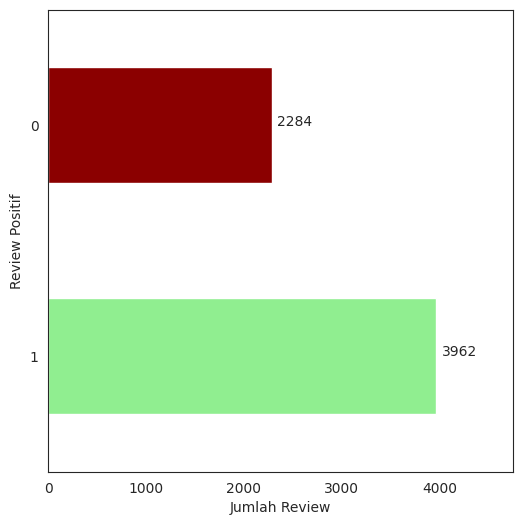

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_palette("muted")

plt.figure(figsize=(6, 6))
counts = train_data_resample["is_positive"].value_counts()
counts.plot(kind="barh", color=["#90EE90", "#8B0000"])

for index, value in enumerate(counts):
    plt.text(value + 60, index, str(value))

plt.xlabel("Jumlah Review")
plt.ylabel("Review Positif")

plt.xlim(0, max(counts) * 1.2)

plt.show()

In [102]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(
    train_data_resample, train_data_resample["is_positive"]
)

train_data_resample = pd.DataFrame(X_resampled, columns=train_data.columns)

print(train_data_resample["is_positive"].value_counts())

is_positive
0    2284
1    2284
Name: count, dtype: int64


nanti datanya akan dicombine ulang untuk analsis lebih lanjut

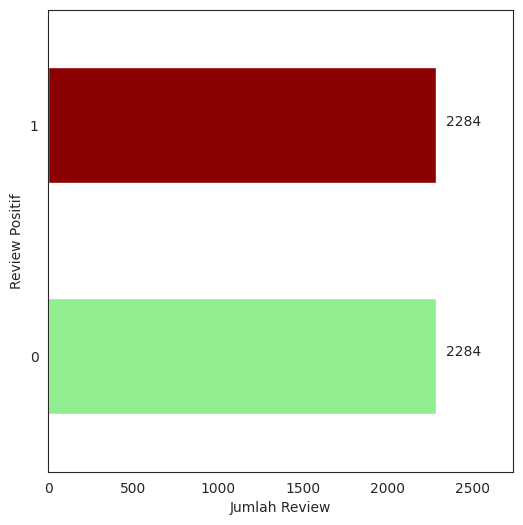

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("white")
sns.set_palette("muted")

plt.figure(figsize=(6, 6))
counts = train_data_resample["is_positive"].value_counts()
counts.plot(kind="barh", color=["#90EE90", "#8B0000"])

for index, value in enumerate(counts):
    plt.text(value + 60, index, str(value))

plt.xlabel("Jumlah Review")
plt.ylabel("Review Positif")

plt.xlim(0, max(counts) * 1.2)

plt.show()

# Model Building

In [104]:
X_train = X_resampled.review_text
y_train = y_resampled

X_val = val_data.review_text
y_val = val_data.is_positive

X_eval = eval_data.review_text
y_eval = eval_data.is_positive

In [105]:
from sklearn.feature_extraction.text import TfidfVectorizer


tfidf_vectorizer = TfidfVectorizer(max_features=100)
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_val_tfidf = tfidf_vectorizer.transform(X_val)
X_eval_tfidf = tfidf_vectorizer.transform(X_eval)

In [106]:
from sklearn.svm import SVC

svm_model = SVC()
svm_model.fit(X_train_tfidf, y_train)

SVC()

In [107]:
from sklearn.metrics import classification_report, accuracy_score

y_val_pred = svm_model.predict(X_val_tfidf)
print("Validation Accuracy:", accuracy_score(y_val, y_val_pred))
print(classification_report(y_val, y_val_pred))

Validation Accuracy: 0.8937259923175416
              precision    recall  f1-score   support

           0       0.81      0.93      0.87       285
           1       0.96      0.87      0.91       496

    accuracy                           0.89       781
   macro avg       0.88      0.90      0.89       781
weighted avg       0.90      0.89      0.90       781



In [108]:
y_eval_pred = svm_model.predict(X_eval_tfidf)
print("Evaluation Accuracy:", accuracy_score(y_eval, y_eval_pred))
print(classification_report(y_eval, y_eval_pred))

Evaluation Accuracy: 0.9167733674775929
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       286
           1       0.96      0.91      0.93       495

    accuracy                           0.92       781
   macro avg       0.91      0.92      0.91       781
weighted avg       0.92      0.92      0.92       781

